#Importing & Cleaning

In [ ]:
#Workbook Management & Formatting
import gdown
import warnings
from google.colab import files
import io
warnings.filterwarnings('ignore')

#Data Wrangling
import pandas as pd
import numpy as np
pd.options.display.float_format='{:.6f}'.format
pd.options.display.max_columns=None

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

#Statistical Analysis & ML
from scipy import stats
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, RFE
from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
url = "https://drive.google.com/uc?id=1iyoI5jIZmsyNcGbm31uY_eEcRs-P3D8e"
output = "W1_general_data.csv"
gdown.download(url, output, quiet=False, fuzzy=True)
raw = pd.read_csv("W1_general_data.csv")

Downloading...
From: https://drive.google.com/uc?id=1iyoI5jIZmsyNcGbm31uY_eEcRs-P3D8e
To: /content/W1_general_data.csv
100%|██████████| 550k/550k [00:00<00:00, 86.5MB/s]


In [ ]:
#uploaded = files.upload()
#raw = pd.read_csv(io.BytesIO(uploaded['W1_general_data.csv']))

Data preview

In [ ]:
raw.head(7)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,1,Healthcare Representative,Married,131160,1.000000,Y,11,8,0,1.000000,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,1,Research Scientist,Single,41890,0.000000,Y,23,8,1,6.000000,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,4,Sales Executive,Married,193280,1.000000,Y,15,8,3,5.000000,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,3,Human Resources,Married,83210,3.000000,Y,11,8,3,13.000000,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,1,Sales Executive,Single,23420,4.000000,Y,12,8,2,9.000000,2,6,0,4
5,46,No,Travel_Rarely,Research & Development,8,3,Life Sciences,1,6,Female,4,Research Director,Married,40710,3.000000,Y,13,8,0,28.000000,5,7,7,7
6,28,Yes,Travel_Rarely,Research & Development,11,2,Medical,1,7,Male,2,Sales Executive,Single,58130,2.000000,Y,20,8,1,5.000000,2,0,0,0


Making self function for data checking

In [ ]:
def check(df):
  for c in df.columns:
    uni = df[c].unique()
    na = df[c].isna().sum()
    unic = df[c].value_counts().to_dict()
    dup = df[c].duplicated().sum()
    dtype = df[c].dtype
    print(f'{c}')
    print(f'DATATYPE: {dtype}')
    print(f'UNIQUE VALUES: {sorted(uni)}')
    print(f'DICT: {unic}')
    print(f'DUPLI: {dup}')
    print(f'NULLS: {na} \n')


In [ ]:
check(raw)

Age
DATATYPE: int64
UNIQUE VALUES: [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
DICT: {35: 234, 34: 231, 31: 207, 36: 207, 29: 204, 32: 183, 30: 180, 38: 174, 33: 174, 40: 171, 37: 150, 28: 144, 27: 144, 42: 138, 39: 126, 45: 123, 41: 120, 26: 117, 46: 99, 44: 99, 43: 96, 50: 90, 24: 78, 25: 78, 49: 72, 47: 72, 55: 66, 48: 57, 51: 57, 53: 57, 52: 54, 54: 54, 22: 48, 58: 42, 23: 42, 56: 42, 21: 39, 20: 33, 59: 30, 19: 27, 18: 24, 60: 15, 57: 12}
DUPLI: 4367
NULLS: 0 

Attrition
DATATYPE: object
UNIQUE VALUES: ['No', 'Yes']
DICT: {'No': 3699, 'Yes': 711}
DUPLI: 4408
NULLS: 0 

BusinessTravel
DATATYPE: object
UNIQUE VALUES: ['Non-Travel', 'Travel_Frequently', 'Travel_Rarely']
DICT: {'Travel_Rarely': 3129, 'Travel_Frequently': 831, 'Non-Travel': 450}
DUPLI: 4407
NULLS: 0 

Department
DATATYPE: object
UNIQUE VALUES: ['Human Resources', 'Research & Development', 'Sa

##Handling missing values

In [ ]:
raw_fill=raw.copy()

In [ ]:
raw_fill['NumCompaniesWorked'] = np.where((raw_fill['TotalWorkingYears'] - raw_fill['YearsAtCompany'] == 1),
                                     0,
                                     raw_fill['NumCompaniesWorked'])
raw_fill['NumCompaniesWorked'] = np.where((raw_fill['TotalWorkingYears'] == raw_fill['YearsAtCompany']),
                                     1,
                                     raw_fill['NumCompaniesWorked'])

In [ ]:
raw_fill['TotalWorkingYears'] = np.where((raw_fill['NumCompaniesWorked']==0),
                                     (raw_fill['YearsAtCompany']+1),
                                     raw_fill['TotalWorkingYears'])
raw_fill['TotalWorkingYears'] = np.where((raw_fill['NumCompaniesWorked']==1),
                                     raw_fill['YearsAtCompany'],
                                     raw_fill['TotalWorkingYears'])

In [ ]:
raw_fill = raw_fill.dropna(subset= ['NumCompaniesWorked','TotalWorkingYears'])

In [ ]:
raw_fill.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4396 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4396 non-null   int64  
 1   Attrition                4396 non-null   object 
 2   BusinessTravel           4396 non-null   object 
 3   Department               4396 non-null   object 
 4   DistanceFromHome         4396 non-null   int64  
 5   Education                4396 non-null   int64  
 6   EducationField           4396 non-null   object 
 7   EmployeeCount            4396 non-null   int64  
 8   EmployeeID               4396 non-null   int64  
 9   Gender                   4396 non-null   object 
 10  JobLevel                 4396 non-null   int64  
 11  JobRole                  4396 non-null   object 
 12  MaritalStatus            4396 non-null   object 
 13  MonthlyIncome            4396 non-null   int64  
 14  NumCompaniesWorked      

##Dropping irrelevant fields

In [ ]:
df0 = raw_fill[['Attrition','EmployeeID','Age','BusinessTravel',
       'DistanceFromHome', 'Education',
       'Gender', 'JobLevel', 'MaritalStatus',
       'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsSinceLastPromotion']]

In [ ]:
# A look in overall data
df0.head(3)

,Attrition,EmployeeID,Age,BusinessTravel,DistanceFromHome,Education,Gender,JobLevel,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion
0,No,1,51,Travel_Rarely,6,2,Female,1,Married,131160,1.000000,11,0,1.000000,6,1,0
1,Yes,2,31,Travel_Frequently,10,1,Female,1,Single,41890,0.000000,23,1,6.000000,3,5,1
2,No,3,32,Travel_Frequently,17,4,Male,4,Married,193280,1.000000,15,3,5.000000,2,5,0


#EDA

In [ ]:
eda=raw_fill[['Attrition', 'Age', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'Gender',
       'JobLevel', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion']]

In [ ]:
eda['Attrition'] = pd.get_dummies(eda['Attrition'], drop_first=True)

In [ ]:
eda.sample()

,Attrition,Age,BusinessTravel,Department,DistanceFromHome,Education,Gender,JobLevel,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion
3781,0,45,Travel_Rarely,Research & Development,4,3,Female,3,Divorced,118360,1.000000,22,10.000000,2,10,7


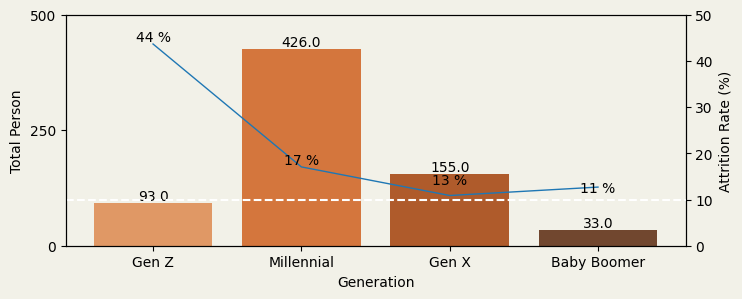

In [ ]:
eda_age = eda.copy()
age_bins = [17, 23, 38, 53, 99]
generational_titles = ['Gen Z', 'Millennial', 'Gen X', 'Baby Boomer']
eda_age['Generation'] = pd.cut(eda_age['Age'], bins = age_bins, labels=generational_titles)
eda_age = eda_age.groupby('Generation').agg(
    total = ('Attrition', 'sum'),
    att_rate = ('Attrition', lambda x: x.sum()/x.count()*100))
eda_age = eda_age.sort_values('att_rate', ascending=False)

fig, ax1 = plt.subplots(figsize=(8,3))
fig.set_facecolor('#F2F1E8')
plt.gca().set_facecolor('#F2F1E8')
ax2 = ax1.twinx()
colors = sns.color_palette('Oranges_d', 4)
sns.barplot(x=eda_age.index, y=eda_age['total'], palette=colors, ax=ax1)

sns.lineplot(x=eda_age.index, y=eda_age['att_rate'], linewidth=1, ax=ax2)
ax1.set_ylabel('Total Person')
ax1.set_yticks(range(0,750,250))
ax2.axhline(y=10, color='white', linestyle='dashed')
ax2.set_ylabel('Attrition Rate (%)')
ax2.set_yticks(range(0,60,10))

for p in ax1.patches:
  ax1.annotate(p.get_height(), (p.get_x() + p.get_width() /2, p.get_height()), ha= 'center', va= 'bottom')
for i,v in enumerate(eda_age['att_rate']):
  ax2.annotate(f'{v:.0f} %', (i,v), ha= 'center', va= 'bottom')

#for i,r in eda_gender.iterrows():
#    plt.annotate(f"{r['att_rate']:.2f}", (i,r['att_rate']),
#                xytext=(0,5), textcoords='offset points', ha='center')

plt.show()

##EDA gender

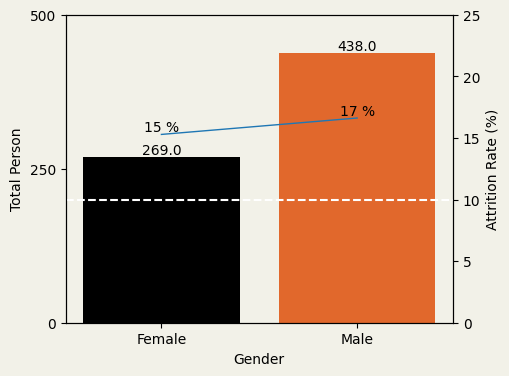

In [ ]:
eda_gender=eda.groupby('Gender').agg(
    qty_each = ('Attrition', 'sum'),
    att_rate = ('Attrition', lambda x: x.sum()/x.count()*100))

fig, ax1 = plt.subplots(figsize=(5,4))
fig.set_facecolor('#F2F1E8')
plt.gca().set_facecolor('#F2F1E8')
ax2 = ax1.twinx()
color_mapping = {'Male': '#FF5E0E', 'Female': 'black'}
sns.barplot(x=eda_gender.index, y=eda_gender['qty_each'], palette=color_mapping, ax=ax1)

sns.lineplot(x=eda_gender.index, y=eda_gender['att_rate'], linewidth=1, ax=ax2)
ax1.set_ylabel('Total Person')
ax1.set_yticks(range(0,750,250))
ax2.axhline(y=10, color='white', linestyle='dashed')
ax2.set_ylabel('Attrition Rate (%)')
ax2.set_yticks(range(0,30,5))

for p in ax1.patches:
  ax1.annotate(p.get_height(), (p.get_x() + p.get_width() /2, p.get_height()), ha= 'center', va= 'bottom')
for i,v in enumerate(eda_gender['att_rate']):
  ax2.annotate(f'{v:.0f} %', (i,v), ha= 'center', va= 'bottom')

#for i,r in eda_gender.iterrows():
#    plt.annotate(f"{r['att_rate']:.2f}", (i,r['att_rate']),
#                xytext=(0,5), textcoords='offset points', ha='center')

plt.show()

## Hypothesis testing 1:<br>
Attrition among gender | H0: attrition rate between genders are the same | alpha 0.05

In [ ]:
MaleXY = eda[['Attrition']][eda['Gender']=='Male']
FemaleXX = eda[['Attrition']][eda['Gender']=='Female']
Genderttest, Genderpvalue=stats.ttest_ind(MaleXY, FemaleXX, equal_var=False)
print('T-test:',Genderttest[0].round(2))
print('P-value:',Genderpvalue[0].round(2))

if Genderpvalue > 0.05:
  print("Accept H0")
else:
  print("Reject H0")

T-test: 1.19
P-value: 0.24
Accept H0


##EDA job level

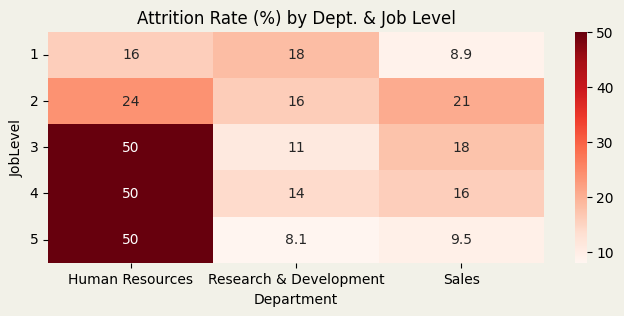

In [ ]:
eda_dept_job = eda.groupby(['Department','JobLevel']).agg(
    att_rate=('Attrition', lambda x: x.sum()/x.count()*100)).reset_index()
eda_dept_job = eda_dept_job.pivot(index='JobLevel', columns='Department', values='att_rate')

fig, ax = plt.subplots(figsize=(8, 3))
fig.patch.set_facecolor('#F2F1E8')
sns.heatmap(data=eda_dept_job, cmap='Reds', annot=True, ax=ax)
plt.title('Attrition Rate (%) by Dept. & Job Level')
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()

##EDA years in company

In [ ]:
eda_co_years = eda.groupby('YearsAtCompany').agg(
    att = ('Attrition', 'sum'),
    total_group = ('YearsAtCompany','count')
).reset_index()

In [ ]:
tenure_bin=[0,4,11,35,41]
eda_co_years['tenure_group'] = pd.cut(eda_co_years['YearsAtCompany'],bins=tenure_bin,labels=['onboarding','settled','dedicated','retiring'],right=False)

In [ ]:
eda_tenuregroup=eda_co_years.groupby('tenure_group').agg(
    att=('att','sum'),
    total_group=('total_group','sum')).reset_index()

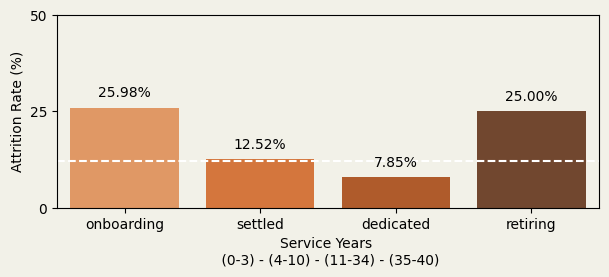

In [ ]:
eda_tenuregroup['att_rate']=eda_tenuregroup['att']/eda_tenuregroup['total_group']*100
fig, ax = plt.subplots(figsize=(7,2.5))
ax.set_facecolor('#F2F1E8')
fig.patch.set_facecolor('#F2F1E8')

orange_palette = sns.color_palette('Oranges_d', 4)

sns.barplot(data=eda_tenuregroup,
            x='tenure_group',
            y='att_rate', palette = orange_palette, ax=ax)
plt.axhline(y=12, color='white', linestyle='dashed')

for i,r in eda_tenuregroup.iterrows():
    plt.annotate(f"{r['att_rate']:.2f}%", (i, r['att_rate']),
                 xytext=(0, 8), textcoords='offset points', ha='center')

plt.xlabel(f"Service Years \n (0-3) - (4-10) - (11-34) - (35-40)")
plt.ylabel('Attrition Rate (%)')
plt.yticks(range(0,75,25))

plt.show()

##EDA career development

In [ ]:
eda_career=eda[['YearsAtCompany','TrainingTimesLastYear','YearsSinceLastPromotion','Attrition']]
eda_career['YearsAtCompany'] = pd.cut(eda_career['YearsAtCompany'],bins=tenure_bin,labels=['onboarding','settled','dedicated','retiring'],right=False)
promo_bin=[0,3,6,11,16]
eda_career['YearsSinceLastPromotion']=pd.cut(eda_career['YearsSinceLastPromotion'], bins=promo_bin, labels=['0-2Y','3-5Y','6-10Y','11-16Y'], right=False)

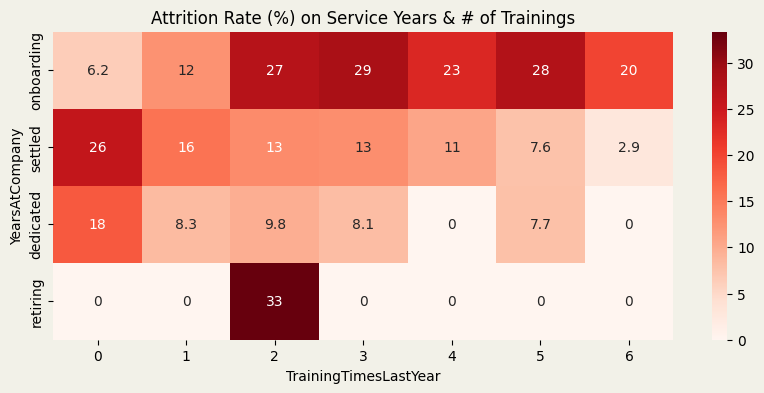

In [ ]:
eda4a=eda_career.groupby(['YearsAtCompany','TrainingTimesLastYear']).agg(
    att_rate=('Attrition', lambda x: x.sum()/x.count()*100)).fillna(0).reset_index()
eda4a=eda4a.pivot(index='YearsAtCompany', columns='TrainingTimesLastYear', values='att_rate')
fig,ax=plt.subplots(figsize=(10,4))
fig.patch.set_facecolor('#F2F1E8')
sns.heatmap(data=eda4a, cmap='Reds', annot=True, ax=ax)
plt.title('Attrition Rate (%) on Service Years & # of Trainings')
plt.show()

In [ ]:
eda4b=eda_career.groupby('YearsAtCompany').agg(
    minTraining=('TrainingTimesLastYear','min'),
    maxTraining=('TrainingTimesLastYear','max'),
    att_rate=('Attrition', lambda x: x.sum()/x.count()*100)).reset_index()

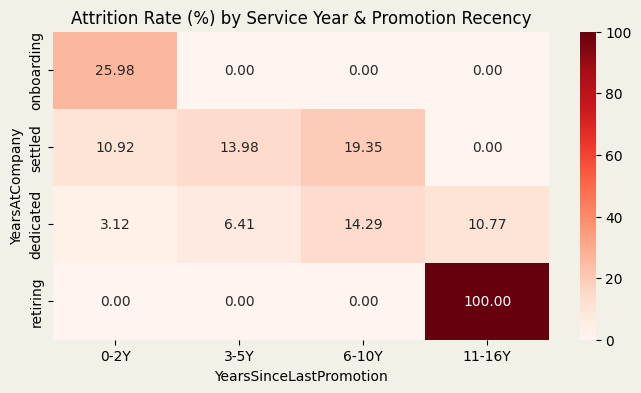

In [ ]:
eda4c=eda_career.groupby(['YearsAtCompany','YearsSinceLastPromotion']).agg(
    att_rate=('Attrition', lambda x: x.sum()/x.count()*100)).reset_index().fillna(0)
eda4c = eda4c.pivot_table(index='YearsAtCompany', columns='YearsSinceLastPromotion', values='att_rate')
fig,ax = plt.subplots(figsize=(8, 4))
fig.patch.set_facecolor('#F2F1E8')
sns.heatmap(eda4c, annot=True, cmap='Reds', fmt='.2f', ax=ax)
plt.title('Attrition Rate (%) by Service Year & Promotion Recency' )
plt.xlabel('YearsSinceLastPromotion')
plt.ylabel('YearsAtCompany')
plt.show()

##EDA salary

In [ ]:
eda_salary=eda[['MonthlyIncome','PercentSalaryHike','JobLevel','Attrition']]
MeanSal1=eda_salary[eda_salary['JobLevel']==1]['MonthlyIncome'].mean()
MeanSal2=eda_salary[eda_salary['JobLevel']==2]['MonthlyIncome'].mean()
MeanSal3=eda_salary[eda_salary['JobLevel']==3]['MonthlyIncome'].mean()
MeanSal4=eda_salary[eda_salary['JobLevel']==4]['MonthlyIncome'].mean()
MeanSal5=eda_salary[eda_salary['JobLevel']==5]['MonthlyIncome'].mean()

In [ ]:
eda_salary['LevelMeanSalary']=eda_salary['JobLevel'].apply(
    lambda x: MeanSal1 if x ==1
    else MeanSal2 if x ==2
    else MeanSal3 if x ==3
    else MeanSal4 if x ==4
    else MeanSal5)

In [ ]:
eda_salary['VSMeanLevel'] = np.where(
    (eda_salary['MonthlyIncome'] > eda_salary['LevelMeanSalary']), 'Above Mean', 'Below Mean')

In [ ]:
joblevelmeansal = eda_salary.groupby('JobLevel').agg(
    MeanSalary=('MonthlyIncome','mean')).reset_index()

In [ ]:
eda_salaryGroup=eda_salary.groupby(['JobLevel','VSMeanLevel']).agg(
    att_rate=('Attrition', lambda x: x.sum()/x.count()*100)).reset_index()
eda_salaryGroup=eda_salaryGroup.pivot(index='VSMeanLevel', columns='JobLevel', values='att_rate')

In [ ]:
joblevelmeansal

,JobLevel,MeanSalary
0,1,62677.366154
1,2,65548.076441
2,3,63450.414110
3,4,77940.754717
4,5,64620.829268


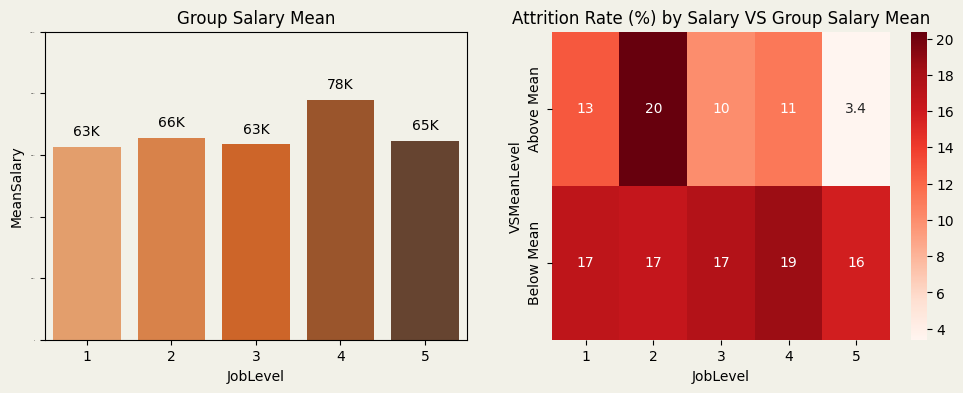

In [ ]:
fig,ax= plt.subplots(1,2, figsize = (12,4))
palette = sns.color_palette('Oranges_d',5)
sns.barplot(data=joblevelmeansal, x='JobLevel', y='MeanSalary', palette = palette, ax=ax[0])
sns.heatmap(data=eda_salaryGroup, cmap='Reds', annot=True, ax=ax[1])
ax[0].set_title('Group Salary Mean')
ax[1].set_title('Attrition Rate (%) by Salary VS Group Salary Mean')
for i,v in joblevelmeansal.iterrows():
    ax[0].annotate(f"{v['MeanSalary']/1000:.0f}K", (i, v['MeanSalary']),
                 xytext=(0, 8), textcoords='offset points', ha='center')
ax[0].set_yticks(range(0,120000,20000))
ax[0].tick_params(axis='y', labelsize=0)
ax[1].set_yticklabels(ax[1].get_yticklabels(), rotation=90)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)
fig.patch.set_facecolor('#F2F1E8')
ax[0].set_facecolor('#F2F1E8')
plt.show()

In [ ]:
eda_salary['PercentSalaryHike'] = pd.cut(eda_salary['PercentSalaryHike'], bins=[9,14,20,26], labels=['fair','good','excellent'], right=True)

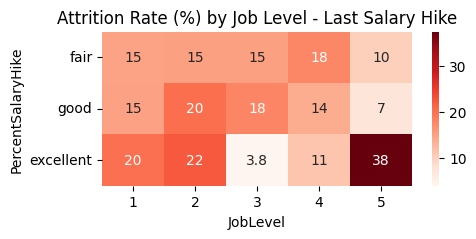

In [ ]:
eda_raise=eda_salary.groupby(['JobLevel','PercentSalaryHike']).agg(
    att_rate=('Attrition', lambda x: x.sum()/x.count()*100)).reset_index()
eda_raise=eda_raise.pivot(index='PercentSalaryHike', columns='JobLevel', values='att_rate')
plt.figure(figsize = (5,2))
sns.heatmap(data=eda_raise, cmap='Reds', annot=True)
plt.title('Attrition Rate (%) by Job Level - Last Salary Hike')
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()

## hypothesis testing 2:<br>
monthly salary vs mean


H0: there is no attrition rate difference between below mean salary group & above mean salary groups

In [ ]:
df1 = df0.copy()
df1['Attrition'] = pd.get_dummies(df1['Attrition'], drop_first = True)

In [ ]:
t_test_salary = df1[['MonthlyIncome','Attrition']]

In [ ]:
mean_salary = t_test_salary['MonthlyIncome'].mean()
print(f'{mean_salary:.2f}')

65029.02


In [ ]:
belowMean = t_test_salary[['Attrition']][t_test_salary['MonthlyIncome'] < mean_salary]
aboveMean = t_test_salary[['Attrition']][t_test_salary['MonthlyIncome'] > mean_salary]

In [ ]:
# Perform a two-sample t-test
t_stat, p_value = stats.ttest_ind(aboveMean, belowMean, equal_var=False)

In [ ]:
print(f't-stat = {t_stat[0]:.2f}')
print(f'p-value = {p_value[0]:.2f}')
if p_value[0] < 0.05:
  print('REJECT H0')
else:
  print('ACCEPT H0')

t-stat = -2.23
p-value = 0.03
REJECT H0


#ML preprocessing & training

In [ ]:
oe = OrdinalEncoder()

In [ ]:
df1_encoded = df1.copy()

In [ ]:
df1_object = df1.select_dtypes(include = 'object')
df1_encoded[df1_object.columns] = oe.fit_transform(df1[df1_object.columns])

In [ ]:
##  0: Divorced
##  1: Married
##  2: Single
df1_encoded.head(3)

,Attrition,EmployeeID,Age,BusinessTravel,DistanceFromHome,Education,Gender,JobLevel,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion
0,0,1,51,2.000000,6,2,0.000000,1,1.000000,131160,1.000000,11,0,1.000000,6,1,0
1,1,2,31,1.000000,10,1,0.000000,1,2.000000,41890,0.000000,23,1,6.000000,3,5,1
2,0,3,32,1.000000,17,4,1.000000,4,1.000000,193280,1.000000,15,3,5.000000,2,5,0


In [ ]:
x1 = df1_encoded.iloc[:,2:]
y1 = df1_encoded.iloc[:,:1]

In [ ]:
x1.info()
print('\n')
y1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4396 entries, 0 to 4409
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4396 non-null   int64  
 1   BusinessTravel           4396 non-null   float64
 2   DistanceFromHome         4396 non-null   int64  
 3   Education                4396 non-null   int64  
 4   Gender                   4396 non-null   float64
 5   JobLevel                 4396 non-null   int64  
 6   MaritalStatus            4396 non-null   float64
 7   MonthlyIncome            4396 non-null   int64  
 8   NumCompaniesWorked       4396 non-null   float64
 9   PercentSalaryHike        4396 non-null   int64  
 10  StockOptionLevel         4396 non-null   int64  
 11  TotalWorkingYears        4396 non-null   float64
 12  TrainingTimesLastYear    4396 non-null   int64  
 13  YearsAtCompany           4396 non-null   int64  
 14  YearsSinceLastPromotion 

from sklearn.feature_selection import SelectKBest, chi2
<br>fs1 = SelectKBest(chi2, k = 14)
<br>x1best = fs1.fit_transform(x1,y1)
<br>x1best = pd.DataFrame(data = x1best, columns = fs1.get_feature_names_out())

##Data training



In [ ]:
categ_vars = ['BusinessTravel', 'Education', 'Gender',
       'JobLevel', 'MaritalStatus', 'StockOptionLevel']
cont_vars = x1.drop(categ_vars, axis=1).columns.values
categ_indices = [x1.columns.get_loc(col) for col in categ_vars]

In [ ]:
x1[categ_vars] = x1[categ_vars].astype(int)

In [ ]:
print(x1[categ_vars].info())
print('\n')
print(x1[cont_vars].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4396 entries, 0 to 4409
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   BusinessTravel    4396 non-null   int64
 1   Education         4396 non-null   int64
 2   Gender            4396 non-null   int64
 3   JobLevel          4396 non-null   int64
 4   MaritalStatus     4396 non-null   int64
 5   StockOptionLevel  4396 non-null   int64
dtypes: int64(6)
memory usage: 240.4 KB
None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4396 entries, 0 to 4409
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4396 non-null   int64  
 1   DistanceFromHome         4396 non-null   int64  
 2   MonthlyIncome            4396 non-null   int64  
 3   NumCompaniesWorked       4396 non-null   float64
 4   PercentSalaryHike        4396 non-null   int64  
 5 

In [ ]:
#Set class object parameter
selectpca = PCA(random_state=42)
smotenc = SMOTENC(random_state=42, categorical_features= categ_indices)
logreg = LogisticRegression(random_state=42)

In [ ]:
#Oversampling
os_x2, os_y2 = smotenc.fit_resample(x1,y1)
os_x2 = pd.DataFrame(data=os_x2, columns=x1.columns)
os_y2 = pd.DataFrame(data=os_y2, columns=y1.columns)

In [ ]:
# Check the numbers of original and oversampled data
print("Length of original data is ", len(x1))
print("Length of oversampled data is ", len(os_x2))
print("Number of no subscription in oversampled data", len(os_y2[os_y2['Attrition'] == 0]))
print("Number of subscription", len(os_y2[os_y2['Attrition'] == 1]))
print("Proportion of positive response in original data is ", len(y1[y1['Attrition'] == 1]) / len(x1)*100,"%")
print("Proportion of positive response in oversampled data is ", len(os_y2[os_y2['Attrition'] == 1]) / len(os_x2)*100,"%")

Length of original data is  4396
Length of oversampled data is  7378
Number of no subscription in oversampled data 3689
Number of subscription 3689
Proportion of positive response in original data is  16.0828025477707 %
Proportion of positive response in oversampled data is  50.0 %


In [ ]:
#Data spliting
x_tr, x_ts, y_tr, y_ts = train_test_split(os_x2, os_y2, train_size = 0.8, random_state=42)

In [ ]:
#Scaling
scaler = StandardScaler()

In [ ]:
Xtr = x_tr.copy()
Xts = x_ts.copy()
Xtr[cont_vars] = scaler.fit_transform(Xtr[cont_vars])
Xts[cont_vars] = scaler.transform(Xts[cont_vars])

In [ ]:
#Principal Component Analysis
X_pca = selectpca.fit_transform(Xtr)
#exp_threshold = 0.95
pcascore = selectpca.explained_variance_ratio_.cumsum()
print(f"Suggested number of variables for model = {len(pcascore[pcascore <= 0.95])}")

Suggested number of variables for model = 12


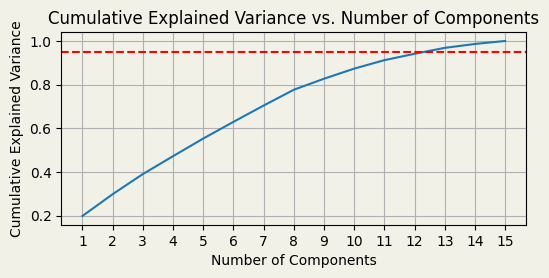

In [ ]:
fig,ax = plt.subplots(figsize=(6,2.5))
plt.plot(range(1,len(pcascore)+1,1), pcascore)
plt.grid(True)
plt.xticks(range(1,16,1))
plt.axhline(y=0.95, color='red', linestyle='dashed')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.gca().set_facecolor('#F2F1E8')
fig.set_facecolor('#F2F1E8')
plt.show()

In [ ]:
#Recursive Feature Elimination
rfe = RFE(estimator=logreg, n_features_to_select=len(x1.columns))
rfe = rfe.fit(Xtr, y_tr.values.ravel())
print(rfe.support_)
print(rfe.ranking_)
print(len(rfe.support_))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
15


In [ ]:
logscores = sm.Logit(y_tr, Xtr).fit()
print(logscores.pvalues[logscores.pvalues<=0.05])
print('\n')
print('VARIABLES TO REMOVE')
print(logscores.pvalues[logscores.pvalues>0.05])
print('\n')
print(f"OPTIMUM VARIABLES= {len(logscores.pvalues[logscores.pvalues<=0.05])}")

Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Age                       0.000000
Education                 0.000000
JobLevel                  0.011691
MaritalStatus             0.000000
MonthlyIncome             0.004609
NumCompaniesWorked        0.000000
StockOptionLevel          0.014538
TotalWorkingYears         0.000000
TrainingTimesLastYear     0.000000
YearsAtCompany            0.000000
YearsSinceLastPromotion   0.000000
dtype: float64


VARIABLES TO REMOVE
BusinessTravel      0.366556
DistanceFromHome    0.859063
Gender              0.598575
PercentSalaryHike   0.052583
dtype: float64


OPTIMUM VARIABLES= 11


In [ ]:
Xtr_clean = Xtr.drop(columns=['BusinessTravel','DistanceFromHome', 'Gender', 'PercentSalaryHike'], axis = 1)
Xts_clean = Xts.drop(columns=['BusinessTravel','DistanceFromHome', 'Gender', 'PercentSalaryHike'], axis = 1)

In [ ]:
logreg.fit(Xtr_clean, y_tr)

LogisticRegression(random_state=42)

In [ ]:
class_report = classification_report(y_tr, logreg.predict(Xtr_clean))
class_report2 = classification_report(y_ts, logreg.predict(Xts_clean))
print("TRAINING")
print(class_report)
print('\n')
print("TEST")
print(class_report2)

TRAINING
              precision    recall  f1-score   support

           0       0.70      0.65      0.67      2944
           1       0.67      0.72      0.69      2958

    accuracy                           0.68      5902
   macro avg       0.68      0.68      0.68      5902
weighted avg       0.68      0.68      0.68      5902



TEST
              precision    recall  f1-score   support

           0       0.72      0.66      0.68       745
           1       0.68      0.74      0.71       731

    accuracy                           0.70      1476
   macro avg       0.70      0.70      0.69      1476
weighted avg       0.70      0.70      0.69      1476



Text(408.9040404040403, 0.5, 'True')

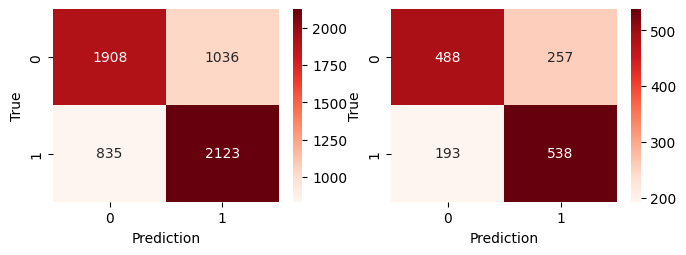

In [ ]:
conmtr = confusion_matrix(y_tr, logreg.predict(Xtr_clean))
conmtr2 = confusion_matrix(y_ts, logreg.predict(Xts_clean))
fig, ax = plt.subplots(1,2, figsize=(8,2.5))
sns.heatmap(conmtr, annot=True, cmap='Reds', fmt='d', ax=ax[0])
sns.heatmap(conmtr2, annot=True, cmap='Reds', fmt='d', ax=ax[1])
ax[0].set_xlabel('Prediction');ax[0].set_ylabel('True')
ax[1].set_xlabel('Prediction');ax[1].set_ylabel('True')

##calculating x variables' odds

In [ ]:
X_coef=logreg.coef_[0]
X_summ = pd.DataFrame({'Variables':Xtr_clean.columns.values,
                        'Coeff':X_coef,
                        'Odds':np.exp(X_coef)}
                        )

In [ ]:
print(f'Intercept:{logreg.intercept_[0]:.2f}')
X_summ.sort_values('Coeff', ascending=False, inplace=True)
X_summ

Intercept:-0.31


,Variables,Coeff,Odds
3,MaritalStatus,0.691634,1.996976
10,YearsSinceLastPromotion,0.361459,1.435422
5,NumCompaniesWorked,0.289098,1.335223
2,JobLevel,-0.037417,0.963275
6,StockOptionLevel,-0.058253,0.943411
4,MonthlyIncome,-0.078429,0.924568
1,Education,-0.158669,0.853279
0,Age,-0.306788,0.735807
7,TotalWorkingYears,-0.314291,0.730306
8,TrainingTimesLastYear,-0.373929,0.688026


Text(0.5, 1.0, 'Odd Ratio Score')

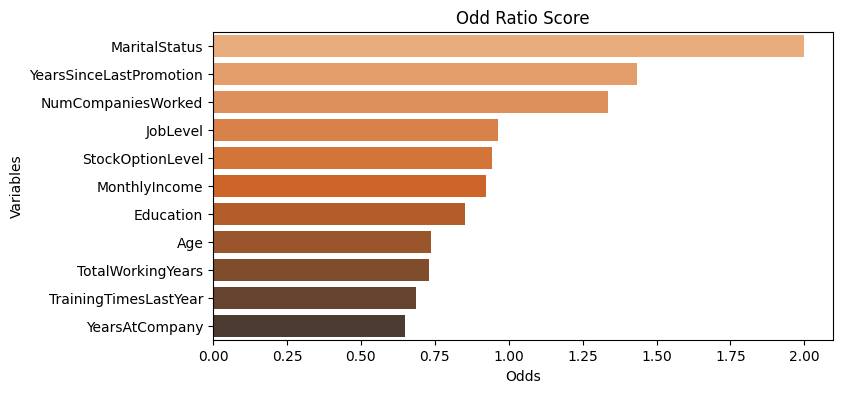

In [ ]:
plt.figure(figsize=(8,4))
palette = sns.color_palette('Oranges_d',11)
sns.barplot(data=X_summ, x='Odds', y='Variables', palette=palette)
plt.title('Odd Ratio Score')

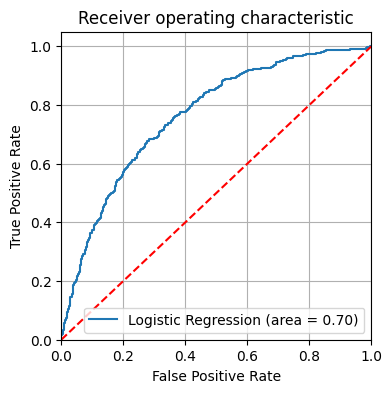

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_ts, logreg.predict(Xts_clean))
fpr, tpr, thresholds = roc_curve(y_ts, logreg.predict_proba(Xts_clean)[:,1])
fig,ax=plt.subplots(figsize=(4,4))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.grid('True')
plt.show()

#New Syntethic Data

In [ ]:
n_sample = 2000
age = np.random.randint(27,37,n_sample)
travel = np.random.choice(['Travel_Rarely', 'Travel_Frequently', 'Non-Travel'],n_sample)
dist = np.random.randint(1,20,n_sample)
education = np.random.randint(2,4,n_sample)
gender = np.random.choice(['Male','Female'],n_sample)
joblevel = np.random.randint(2,4,n_sample)
marital = np.random.choice(['Single','Married','Divorced'],n_sample)
inco = np.random.randint(50000,175000,n_sample)
numco = np.random.randint(2,6,n_sample)
hike = np.random.randint(10,20,n_sample)
stokop = np.random.randint(0,2,n_sample)
wyear = np.random.randint(5,17,n_sample)
yeartrain = np.random.randint(0,7,n_sample)
coyear = np.random.randint(0,10,n_sample)

In [ ]:
lastpromo = np.random.randint(0,5,n_sample)

In [ ]:
new_raw_data=pd.DataFrame([age,travel,dist,education,gender,joblevel,marital,inco,numco,hike,stokop,wyear,yeartrain,coyear,lastpromo]).transpose()
new_raw_data.columns = x1.columns
new_raw_data.head()

,Age,BusinessTravel,DistanceFromHome,Education,Gender,JobLevel,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion
0,35,Non-Travel,5,3,Female,3,Divorced,121085,4,17,0,5,3,7,1
1,33,Travel_Rarely,4,3,Male,3,Single,141544,4,18,0,6,1,1,2
2,32,Travel_Frequently,13,2,Male,3,Married,110042,4,17,1,11,3,7,4
3,27,Travel_Rarely,14,2,Female,2,Divorced,116604,5,19,0,12,0,7,3
4,36,Travel_Frequently,18,2,Male,2,Married,129498,5,14,1,15,1,6,1


##making new data more sensical

condition must be met: Total Working Years >= Years At Company >= Years Last Promotion

In [ ]:
new_raw_data=new_raw_data[(new_raw_data['YearsAtCompany']<=new_raw_data['TotalWorkingYears']) & (new_raw_data['YearsSinceLastPromotion']<=new_raw_data['YearsAtCompany'])]

In [ ]:
new_int = new_raw_data[['Age', 'DistanceFromHome', 'Education',
       'JobLevel',  'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion']].astype(int)
new_raw_data[new_int.columns]=new_int

In [ ]:
new_obj = new_raw_data.select_dtypes(include=object)
new_obj[new_obj.columns] = oe.transform(new_obj)

In [ ]:
new_raw_data.sample(10)

,Age,BusinessTravel,DistanceFromHome,Education,Gender,JobLevel,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion
119,35,Non-Travel,19,3,Female,2,Divorced,167594,3,19,1,15,2,5,2
952,31,Travel_Rarely,12,3,Female,2,Single,157053,4,18,1,10,1,4,0
518,29,Travel_Frequently,18,2,Male,2,Married,109280,4,16,1,15,5,7,1
509,34,Non-Travel,3,3,Male,3,Married,107661,3,19,1,5,5,1,0
1725,36,Travel_Frequently,11,3,Female,2,Single,74875,3,12,0,16,2,5,1
1456,34,Non-Travel,4,2,Female,2,Single,114763,2,11,1,8,5,6,3
1441,35,Travel_Frequently,10,3,Female,2,Single,107899,3,14,0,7,0,4,2
1637,29,Travel_Rarely,6,2,Male,2,Single,82903,4,13,1,6,1,5,4
1323,33,Travel_Rarely,4,3,Female,2,Single,174426,3,18,1,14,3,9,1
53,33,Travel_Frequently,17,3,Female,2,Single,105930,4,16,0,6,5,1,1


In [ ]:
new_raw_csv = new_raw_data.copy()
new_raw_csv.to_csv('new_raw_attrition.csv', index= False)
#files.download('new_raw_attrition.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
new_data = new_raw_data.copy()
new_data[new_obj.columns] = new_obj
new_data.head(3)

,Age,BusinessTravel,DistanceFromHome,Education,Gender,JobLevel,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion
0,33,1.000000,7,2,1.000000,3,0.000000,54440,4,13,0,11,4,6,4
2,27,0.000000,7,3,0.000000,2,2.000000,79756,3,10,1,9,1,4,0
3,34,2.000000,7,2,1.000000,2,2.000000,111314,2,17,1,10,4,8,0


In [ ]:
x_new=new_data.copy()

In [ ]:
x_new[cont_vars]=scaler.transform(x_new[cont_vars])

In [ ]:
x_new=x_new[logreg.feature_names_in_]

In [ ]:
x_new

,Age,Education,JobLevel,MaritalStatus,MonthlyIncome,NumCompaniesWorked,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion
0,-0.274271,2,3,0.000000,-0.197635,0.509839,0,0.121131,1.111487,-0.020709,0.633705
2,-0.933503,3,2,2.000000,0.352447,0.109967,1,-0.149697,-1.379966,-0.367450,-0.663599
3,-0.164399,2,2,2.000000,1.038159,-0.289904,1,-0.014283,1.111487,0.326031,-0.663599
5,-0.494015,2,3,1.000000,1.294058,0.109967,1,0.256546,1.111487,0.152661,-0.663599
6,-0.603887,2,3,2.000000,2.320779,-0.289904,0,-0.420525,0.281003,-0.540820,-0.014947
...,...,...,...,...,...,...,...,...,...,...,...
1992,-0.384143,3,3,2.000000,0.696759,0.509839,0,-0.014283,-2.210450,-0.194079,-0.663599
1993,-0.164399,3,2,1.000000,2.222696,0.909711,0,-0.285111,0.281003,-0.194079,0.309379
1994,-0.823631,2,2,0.000000,0.535033,-0.289904,0,0.391960,2.772455,0.326031,-0.014947
1995,-0.164399,2,3,0.000000,0.188526,-0.289904,0,0.798202,-1.379966,-0.020709,0.309379


##predicting new data

In [ ]:
att=logreg.predict(x_new)
att_proba=logreg.predict_proba(x_new)

In [ ]:
new_data_att=new_data.copy()
new_data_att['AttritionProba']=att_proba[:,1]
new_data_att['Attrition']=att

In [ ]:
employees_to_watch= new_data_att[new_data_att['AttritionProba'] > 0.5].shape[0]
print(f"n Employees to WATCH: {employees_to_watch} out of {len(new_data)}")

n Employees to WATCH: 694 out of 1461


In [ ]:
watch_list=new_data_att[new_data_att['AttritionProba'] > 0.5]

In [ ]:
watch_list

,Age,BusinessTravel,DistanceFromHome,Education,Gender,JobLevel,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,AttritionProba,Attrition
2,27,0.000000,7,3,0.000000,2,2.000000,79756,3,10,1,9,1,4,0,0.775198,1
6,30,2.000000,16,2,0.000000,3,2.000000,170343,2,16,0,7,3,3,2,0.694085,1
10,27,0.000000,8,2,0.000000,3,1.000000,55021,4,16,1,14,1,4,3,0.723954,1
14,27,0.000000,11,3,0.000000,3,2.000000,151494,2,13,0,12,4,6,2,0.511763,1
16,29,0.000000,1,3,0.000000,3,0.000000,51682,5,14,0,7,0,7,0,0.564463,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,34,2.000000,13,3,0.000000,3,0.000000,62108,5,10,0,7,0,4,0,0.573575,1
1990,27,2.000000,18,3,0.000000,2,2.000000,159318,4,17,1,14,2,9,0,0.579844,1
1992,32,2.000000,5,3,1.000000,3,2.000000,95602,4,11,0,10,0,5,0,0.797750,1
1993,34,0.000000,5,3,1.000000,2,1.000000,165829,5,18,0,8,3,5,3,0.537869,1


In [ ]:
watch_list.AttritionProba.mean().round(2)

0.66

In [ ]:
new_data_att.AttritionProba.mean().round(2)

0.48

In [ ]:
"""from collections import Counter
from numpy.random import RandomState
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTENC
X, y = make_classification(n_classes=2, class_sep=2,
weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
print(f'Original dataset shape {X.shape}')
print(f'Original dataset samples per class {Counter(y)}')
# simulate the 2 last columns to be categorical features
X[:, -2:] = RandomState(10).randint(0, 4, size=(1000, 2))
sm = SMOTENC(random_state=42, categorical_features=[18, 19])
X_res, y_res = sm.fit_resample(X, y)
print(f'Resampled dataset samples per class {Counter(y_res)}')